In [1]:
from pcg_gazebo.generators import WorldGenerator
from pcg_gazebo.visualization import plot_workspace, plot_occupancy_grid
from pcg_gazebo.generators.creators import box_factory

world_gen = WorldGenerator()

Add a dynamic box generator to the list of assets. Dynamic boxes have a mass and moments of inertia.

In [2]:
world_gen.add_asset(
    tag='dyn_box',
    description=dict(
        type='box',
        args=dict(
            size="5 * __import__('numpy').random.random(3)",
            name='cuboid',
            mass="max(0.1, __import__('numpy').random.random())",
            color='xkcd'
        )
    )
)

# Check if models where included correctly
print('Assets available for world generation=', world_gen.assets.tags)

Assets available for world generation= ['dyn_box', 'cardboard_box', 'arm_part', 'euro_pallet', 'walls', 'speed_limit_sign', 'mobile_base', 'OrangeDoors', 'sun', 'double_pendulum_with_base', 'ground_plane', 'hinged_door']


In [3]:
world_gen.add_asset(
    tag='static_cylinder',
    description=dict(
        type='cylinder',
        args=dict(
            length="2 * __import__('numpy').random.random()",
            radius="2 * __import__('numpy').random.random()",
            name='cylinder',
            color='xkcd'
        )
    )
)

# Check if models where included correctly
print('Assets available for world generation=', world_gen.assets.tags)

Assets available for world generation= ['dyn_box', 'static_cylinder', 'cardboard_box', 'arm_part', 'euro_pallet', 'walls', 'speed_limit_sign', 'mobile_base', 'OrangeDoors', 'sun', 'double_pendulum_with_base', 'ground_plane', 'hinged_door']


Add a constraint to ensure all boxes are placed on top of ground plane

In [4]:
world_gen.add_constraint(
    name='tangent_to_ground_plane',
    type='tangent',
    frame='world',
    reference=dict(
        type='plane',
        args=dict(
            origin=[0, 0, 0],
            normal=[0, 0, 1]
        )
    )
)

print('List of constraints=', list(world_gen.constraints.tags))

List of constraints= ['tangent_to_ground_plane']


Add 2D workspace constraint defining where the boxes should be spawned in the world

List of constraints= ['tangent_to_ground_plane', 'my_workspace']


(<Figure size 1440x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f38aeedfe80>)

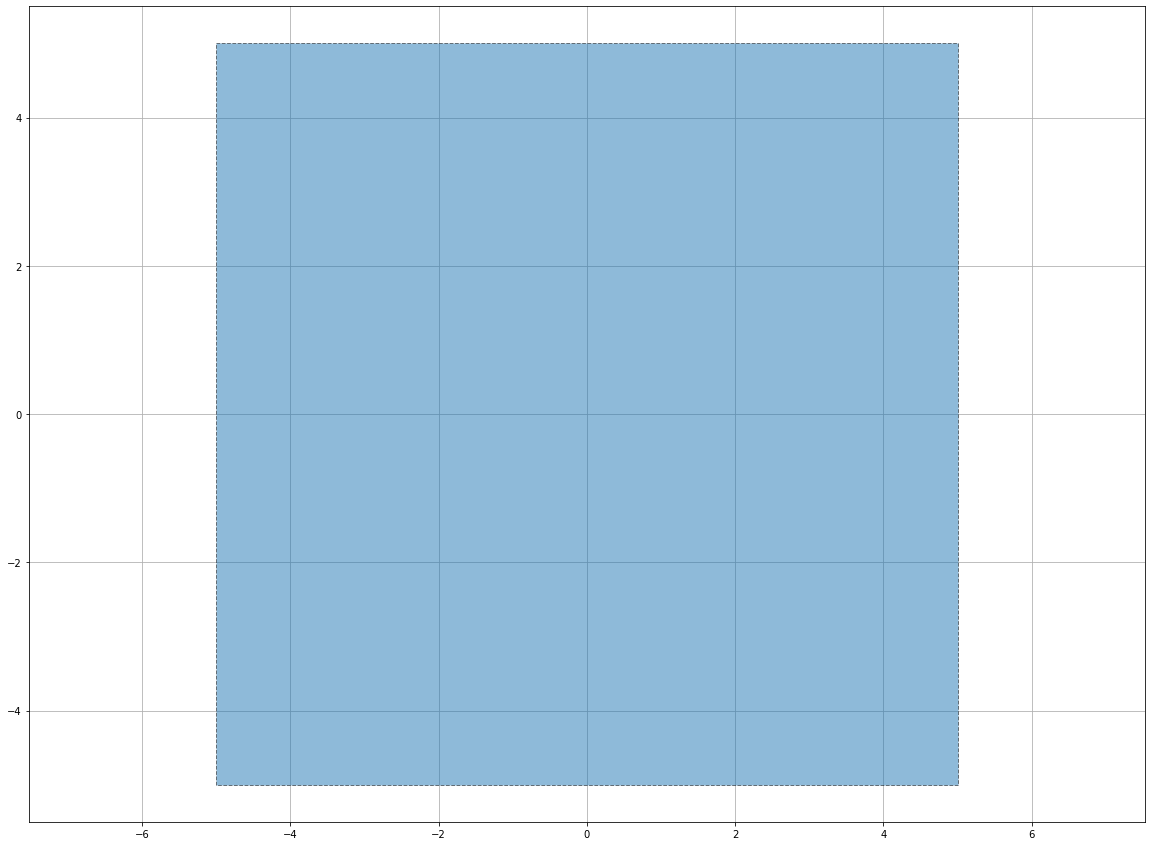

In [5]:
world_gen.add_constraint(
    name='my_workspace',
    type='workspace',
    frame='world',
    geometry=dict(
        type='area',
        description=dict(
            points=[
                [-5, -5, 0],
                [-5, 5, 0],
                [5, 5, 0],
                [5, -5, 0],
            ]
        )
    )
)

print('List of constraints=', list(world_gen.constraints.tags))

plot_workspace(workspace=world_gen.constraints.get('my_workspace'))

Add ground plane to the world in a fixed position

In [6]:
floor_model = box_factory(
    size=[
        [20, 20, 0.01]
    ],
    mass=1,
    use_permutation=True,
    name='box_floor'
)[0]
floor_model.name = 'box_floor'

world_gen.add_asset(tag='box_floor', description=floor_model)

world_gen.add_engine(
    engine_name='fixed_pose',
    tag='gp_engine',
    models=['box_floor'],
    poses=[[0, 0, -0.005, 0, 0, 0]])
world_gen.set_model_as_ground_plane('box_floor')

--- BOX CREATOR
Setting inertial,  box_floor_0 1.0 [20.0, 20.0, 0.01]
<inertial>
  <inertia>
    <ixx>33.33334166666666</ixx>
    <iyy>33.33334166666666</iyy>
    <izz>66.66666666666666</izz>
    <ixy>0.0</ixy>
    <ixz>0.0</ixz>
    <iyz>0.0</iyz>
  </inertia>
  <pose frame="">0 0 0 0 -0 0</pose>
  <mass>1.0</mass>
</inertial>

Inertial after setting pose,  box_floor_0 <pose frame="">0 0 0 0 -0 0</pose>

<inertial>
  <inertia>
    <ixx>33.33334166666666</ixx>
    <iyy>33.33334166666666</iyy>
    <izz>66.66666666666666</izz>
    <ixy>0.0</ixy>
    <ixz>0.0</ixz>
    <iyz>0.0</iyz>
  </inertia>
  <pose frame="">0 0 0 0 -0 0</pose>
  <mass>1.0</mass>
</inertial>

<inertial>
  <inertia>
    <ixx>33.33334166666666</ixx>
    <iyy>33.33334166666666</iyy>
    <izz>66.66666666666666</izz>
    <ixy>0.0</ixy>
    <ixz>0.0</ixz>
    <iyz>0.0</iyz>
  </inertia>
  <pose frame="">0 0 0 0 -0 0</pose>
  <mass>1.0</mass>
</inertial>

--- BOX CREATOR


True

Add a random pose engine to place the boxes in the world

In [7]:
NUM_BOXES = 2
NUM_CYLINDER = 2

box_placement_policy = dict(
    models=['dyn_box', 'static_cylinder'],
    config=[
        dict(
            dofs=['x', 'y'],
            policy=dict(
                name='workspace',
                args='my_workspace'
            )
        ),
        dict(
            dofs=['yaw'],
            policy=dict(
                name='uniform',
                args=dict(
                    mean=0,
                    min=-3.141592653589793,
                    max=3.141592653589793
                )
            )
        )
    ]
)

world_gen.add_engine(
    tag='box_placement',
    engine_name='random_pose',
    models=['dyn_box', 'static_cylinder'],
    max_num=dict(
        dyn_box=NUM_BOXES,
        static_cylinder=NUM_CYLINDER),
    model_picker='random',
    no_collision=True,
    policies=[box_placement_policy],
    constraints=[
        dict(
            model='dyn_box',
            constraint='tangent_to_ground_plane'),
        dict(
            model='static_cylinder',
            constraint='tangent_to_ground_plane')
    ]
)

workspace {'workspace': 'my_workspace', 'dofs': ['x', 'y']}
uniform {'mean': 0, 'min': -3.141592653589793, 'max': 3.141592653589793, 'dofs': ['yaw']}


True

Run the engines to generate the world

In [8]:
world_gen.run_engines()

--- ASSETS MANAGER= static_cylinder
<model name="static_cylinder">
  <pose frame="">0 0 0 0 -0 0</pose>
  <static>1</static>
  <self_collide>0</self_collide>
  <allow_auto_disable>0</allow_auto_disable>
  <link name="link">
    <static>0</static>
    <kinematic>0</kinematic>
    <gravity>1</gravity>
    <self_collide>0</self_collide>
    <collision name="collision">
      <geometry>
        <cylinder>
          <radius>0.8532314900701974</radius>
          <length>1.2834935860078043</length>
        </cylinder>
      </geometry>
      <pose frame="">0 0 0 0 -0 0</pose>
      <max_contacts>20</max_contacts>
    </collision>
    <visual name="visual">
      <geometry>
        <cylinder>
          <radius>0.8532314900701974</radius>
          <length>1.2834935860078043</length>
        </cylinder>
      </geometry>
      <material>
        <ambient>0.537255 0.270588 0.521569 1</ambient>
        <diffuse>0.537255 0.270588 0.521569 1</diffuse>
      </material>
      <pose frame="">0 0 0 0 

True

In [9]:
print(world_gen.world.models.keys())

dict_keys(['box_floor', 'static_cylinder', 'dyn_box', 'dyn_box_1', 'static_cylinder_1'])


In [10]:
#world_gen.world.show()

Next the grid map can be generated. It is important to check if the dynamic models should be included in the plot. 
That can be done using the `static_models_only` input.
The example below shows a grid map with both dynamic and static models. 

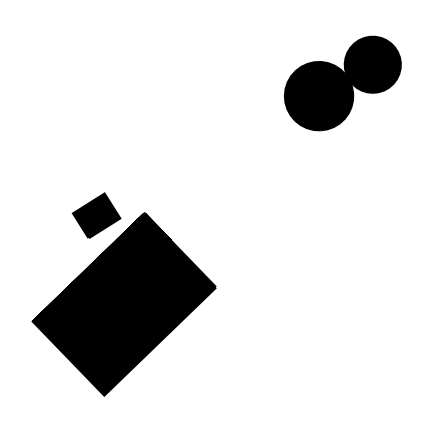

In [11]:
import matplotlib.pyplot as pyplot
fig = plot_occupancy_grid(
    world_gen.world.models,
    with_ground_plane=False,
    static_models_only=False)
pyplot.show()

The example below shows a grid map with only static models. 

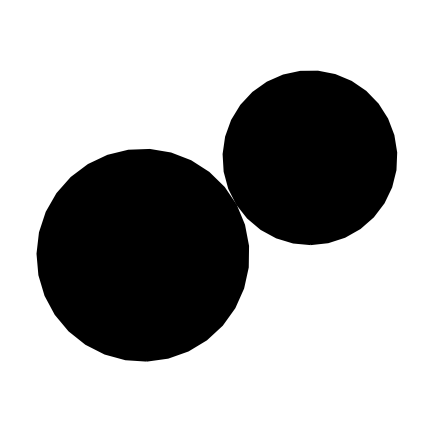

In [12]:
fig = plot_occupancy_grid(
    world_gen.world.models,
    with_ground_plane=False,
    static_models_only=True)
pyplot.show()

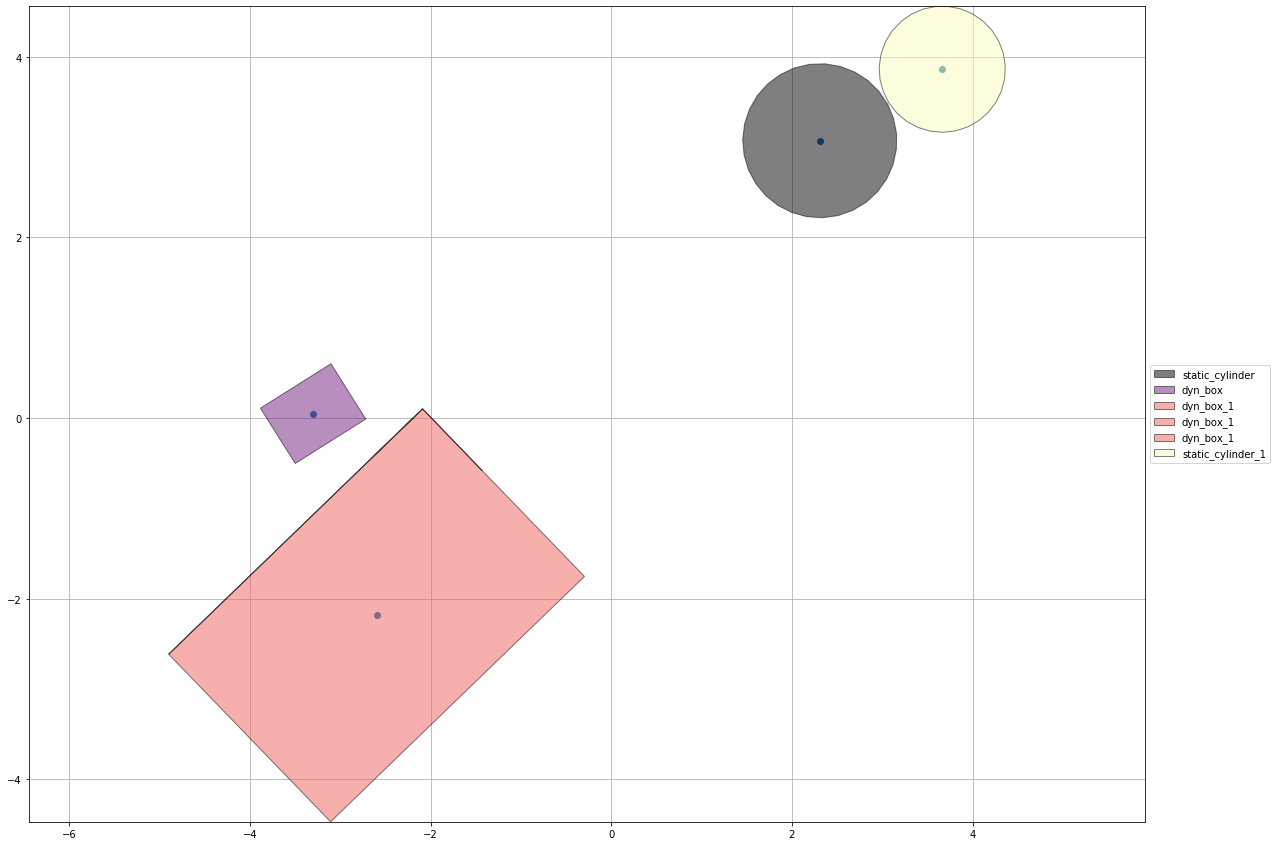

In [13]:
fig = world_gen.world.plot_footprints(engine='matplotlib')